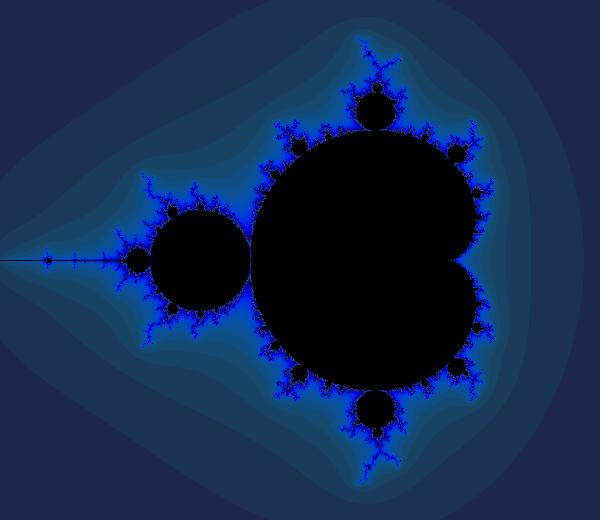

In [1]:
# Import libraries for simulation
import tensorflow as tf
import numpy as np

# Imports for visualization
import PIL.Image
from cStringIO import StringIO
from IPython.display import clear_output, Image, display
import scipy.ndimage as nd


def DisplayFractal(a, fmt='jpeg'):
  """Display an array of iteration counts as a
     colorful picture of a fractal."""
  a_cyclic = (6.28*a/30).reshape(list(a.shape)+[1])
  img = np.concatenate([10+20*np.cos(a_cyclic),
                        30+50*np.sin(a_cyclic),
                        155-80*np.cos(a_cyclic)], 2)
  img[a==a.max()] = 0
  a = img
  a = np.uint8(np.clip(a, 0, 255))
  f = StringIO()
  PIL.Image.fromarray(a).save(f, fmt)
  display(Image(data=f.getvalue()))

def main():
    sess = tf.InteractiveSession()

    Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]
    Z = X+1j*Y

    xs = tf.constant(Z.astype("complex64"))
    zs = tf.Variable(xs)
    ns = tf.Variable(tf.zeros_like(xs, "float32"))

    tf.initialize_all_variables().run()


    # Compute the new values of z: z^2 + x
    zs_ = zs*zs + xs

    # Have we diverged with this new value?
    not_diverged = tf.complex_abs(zs_) < 4

    # Operation to update the zs and the iteration count.
    #
    # Note: We keep computing zs after they diverge! This
    #       is very wasteful! There are better, if a little
    #       less simple, ways to do this.
    #
    step = tf.group(
        zs.assign(zs_),
      ns.assign_add(tf.cast(not_diverged, "float32"))
      )

    for i in range(1000): step.run()

    DisplayFractal(ns.eval())

main()

In [2]:
# Copyright 2015 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Builds the MNIST network.
Implements the inference/loss/training pattern for model building.
1. inference() - Builds the model as far as is required for running the network
forward to make predictions.
2. loss() - Adds to the inference model the layers required to generate loss.
3. training() - Adds to the loss model the Ops required to generate and
apply gradients.
This file is used by the various "fully_connected_*.py" files and not meant to
be run.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import math
import tensorflow.python.platform
import tensorflow as tf
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10
# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
def inference(images, hidden1_units, hidden2_units):
    """Build the MNIST model up to where it may be used for inference.
    Args:
    images: Images placeholder, from inputs().
    hidden1_units: Size of the first hidden layer.
    hidden2_units: Size of the second hidden layer.
    Returns:
    softmax_linear: Output tensor with the computed logits.
    """
    # Hidden 1
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([IMAGE_PIXELS, hidden1_units],
                                stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden1_units]),
                         name='biases')
        hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
    # Hidden 2
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
        tf.truncated_normal([hidden1_units, hidden2_units],
                            stddev=1.0 / math.sqrt(float(hidden1_units))),
        name='weights')
        biases = tf.Variable(tf.zeros([hidden2_units]),
                         name='biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
    # Linear
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hidden2_units, NUM_CLASSES],
                            stddev=1.0 / math.sqrt(float(hidden2_units))),
        name='weights')
        biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                         name='biases')
        logits = tf.matmul(hidden2, weights) + biases
    return logits

def loss(logits, labels):
    """Calculates the loss from the logits and the labels.
    Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor, int32 - [batch_size].
    Returns:
    loss: Loss tensor of type float.
    """
    # Convert from sparse integer labels in the range [0, NUM_CLASSSES)
    # to 1-hot dense float vectors (that is we will have batch_size vectors,
    # each with NUM_CLASSES values, all of which are 0.0 except there will
    # be a 1.0 in the entry corresponding to the label).
    batch_size = tf.size(labels)
    labels = tf.expand_dims(labels, 1)
    indices = tf.expand_dims(tf.range(0, batch_size), 1)
    concated = tf.concat(1, [indices, labels])
    onehot_labels = tf.sparse_to_dense(
      concated, tf.pack([batch_size, NUM_CLASSES]), 1.0, 0.0)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits,
                                                          onehot_labels,
                                                          name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    return loss
def training(loss, learning_rate):
    """Sets up the training Ops.
    Creates a summarizer to track the loss over time in TensorBoard.
    Creates an optimizer and applies the gradients to all trainable variables.
    The Op returned by this function is what must be passed to the
    `sess.run()` call to cause the model to train.
    Args:
    loss: Loss tensor, from loss().
    learning_rate: The learning rate to use for gradient descent.
    Returns:
    train_op: The Op for training.
    """
    # Add a scalar summary for the snapshot loss.
    tf.scalar_summary(loss.op.name, loss)
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op

def evaluation(logits, labels):
    """Evaluate the quality of the logits at predicting the label.
    Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor, int32 - [batch_size], with values in the
      range [0, NUM_CLASSES).
    Returns:
    A scalar int32 tensor with the number of examples (out of batch_size)
    that were predicted correctly.
    """
    # For a classifier model, we can use the in_top_k Op.
    # It returns a bool tensor with shape [batch_size] that is true for
    # the examples where the label's is was in the top k (here k=1)
    # of all logits for that example.
    correct = tf.nn.in_top_k(logits, labels, 1)
    # Return the number of true entries.
    return tf.reduce_sum(tf.cast(correct, tf.int32))

In [7]:
# Copyright 2015 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Trains and Evaluates the MNIST network using a feed dictionary."""
# pylint: disable=missing-docstring

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os.path
import time
import tensorflow.python.platform
import numpy
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
#from tensorflow.examples.tutorials.mnist import mnist
import mnist

# Basic model parameters as external flags.
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('max_steps', 2000, 'Number of steps to run trainer.')
flags.DEFINE_integer('hidden1', 128, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 32, 'Number of units in hidden layer 2.')
flags.DEFINE_integer('batch_size', 100, 'Batch size. Must divide evenly into the dataset sizes.')
flags.DEFINE_string('train_dir', 'data', 'Directory to put the training data.')
flags.DEFINE_boolean('fake_data', False, 'If true, uses fake data for unit testing.')

def placeholder_inputs(batch_size):
    """Generate placeholder variables to represent the the input tensors.
    These placeholders are used as inputs by the rest of the model building
    code and will be fed from the downloaded data in the .run() loop, below.
    Args:
    batch_size: The batch size will be baked into both placeholders.
    Returns:
    images_placeholder: Images placeholder.
    labels_placeholder: Labels placeholder.
    """
    # Note that the shapes of the placeholders match the shapes of the full
    # image and label tensors, except the first dimension is now batch_size
    # rather than the full size of the train or test data sets.

    images_placeholder = tf.placeholder(tf.float32, shape=(batch_size,
                                                         mnist.IMAGE_PIXELS))
    labels_placeholder = tf.placeholder(tf.int32, shape=(batch_size))
    return images_placeholder, labels_placeholder


def fill_feed_dict(data_set, images_pl, labels_pl):
    """Fills the feed_dict for training the given step.
    A feed_dict takes the form of:
    feed_dict = {
      <placeholder>: <tensor of values to be passed for placeholder>,
      ....
    }
    Args:
    data_set: The set of images and labels, from input_data.read_data_sets()
    images_pl: The images placeholder, from placeholder_inputs().
    labels_pl: The labels placeholder, from placeholder_inputs().
    Returns:
    feed_dict: The feed dictionary mapping from placeholders to values.
    """
    # Create the feed_dict for the placeholders filled with the next
    # `batch size ` examples.
    images_feed, labels_feed = data_set.next_batch(FLAGS.batch_size,
                                                 FLAGS.fake_data)
    feed_dict = {
      images_pl: images_feed,
      labels_pl: labels_feed,
    }
    return feed_dict


def do_eval(sess,
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_set):
    """Runs one evaluation against the full epoch of data.
    Args:
    sess: The session in which the model has been trained.
    eval_correct: The Tensor that returns the number of correct predictions.
    images_placeholder: The images placeholder.
    labels_placeholder: The labels placeholder.
    data_set: The set of images and labels to evaluate, from
      input_data.read_data_sets().
    """
    # And run one epoch of eval.
    true_count = 0  # Counts the number of correct predictions.
    steps_per_epoch = data_set.num_examples // FLAGS.batch_size
    num_examples = steps_per_epoch * FLAGS.batch_size
    for step in xrange(steps_per_epoch):
        feed_dict = fill_feed_dict(data_set,
                                   images_placeholder,
                                   labels_placeholder)
        true_count += sess.run(eval_correct, feed_dict=feed_dict)
    precision = true_count / num_examples
    print('  Num examples: %d  Num correct: %d  Precision @ 1: %0.04f' %(num_examples, true_count, precision))

def run_training():
    """Train MNIST for a number of steps."""
    # Get the sets of images and labels for training, validation, and
    # test on MNIST.
    data_sets = input_data.read_data_sets(FLAGS.train_dir, FLAGS.fake_data)
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # Generate placeholders for the images and labels.
        images_placeholder, labels_placeholder = placeholder_inputs(
            FLAGS.batch_size)
        # Build a Graph that computes predictions from the inference model.
        logits = mnist.inference(images_placeholder,
                                 FLAGS.hidden1,
                                 FLAGS.hidden2)
        # Add to the Graph the Ops for loss calculation.
        loss = mnist.loss(logits, labels_placeholder)
        # Add to the Graph the Ops that calculate and apply gradients.
        train_op = mnist.training(loss, FLAGS.learning_rate)
        # Add the Op to compare the logits to the labels during evaluation.
        eval_correct = mnist.evaluation(logits, labels_placeholder)
        # Build the summary operation based on the TF collection of Summaries.
        summary_op = tf.merge_all_summaries()
        # Create a saver for writing training checkpoints.
        saver = tf.train.Saver()
        # Create a session for running Ops on the Graph.
        sess = tf.Session()
        # Run the Op to initialize the variables.
        init = tf.initialize_all_variables()
        sess.run(init)
        # Instantiate a SummaryWriter to output summaries and the Graph.
        summary_writer = tf.train.SummaryWriter(FLAGS.train_dir,
                                                graph_def=sess.graph_def)
        # And then after everything is built, start the training loop.
        for step in xrange(FLAGS.max_steps):
            start_time = time.time()
            # Fill a feed dictionary with the actual set of images and labels
            # for this particular training step.
            feed_dict = fill_feed_dict(data_sets.train,
                                     images_placeholder,
                                     labels_placeholder)
            # Run one step of the model.  The return values are the activations
            # from the `train_op` (which is discarded) and the `loss` Op.  To
            # inspect the values of your Ops or variables, you may include them
            # in the list passed to sess.run() and the value tensors will be
            # returned in the tuple from the call.
            _, loss_value = sess.run([train_op, loss],
                                   feed_dict=feed_dict)
            duration = time.time() - start_time
            # Write the summaries and print an overview fairly often.
            if step % 100 == 0:
                # Print status to stdout.
                print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
                # Update the events file.
                summary_str = sess.run(summary_op, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
            # Save a checkpoint and evaluate the model periodically.
            if (step + 1) % 1000 == 0 or (step + 1) == FLAGS.max_steps:
                saver.save(sess, FLAGS.train_dir, global_step=step)
                # Evaluate against the training set.
                print('Training Data Eval:')
                do_eval(sess,
                        eval_correct,
                        images_placeholder,
                        labels_placeholder,
                        data_sets.train)
                # Evaluate against the validation set.
                print('Validation Data Eval:')
                do_eval(sess,
                        eval_correct,
                        images_placeholder,
                        labels_placeholder,
                        data_sets.validation)
                # Evaluate against the test set.
                print('Test Data Eval:')
                do_eval(sess,
                        eval_correct,
                        images_placeholder,
                        labels_placeholder,
                        data_sets.test)

def main(_):
    run_training()
    
if __name__ == '__main__':
    tf.app.run()

usage: __main__.py [-h] [--learning_rate LEARNING_RATE]
                   [--max_steps MAX_STEPS] [--hidden1 HIDDEN1]
                   [--hidden2 HIDDEN2] [--batch_size BATCH_SIZE]
                   [--train_dir TRAIN_DIR] [--fake_data FAKE_DATA]
                   [--nofake_data]
__main__.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-63b54c44-7a55-4dd2-9a83-0d03d79c947d.json


SystemExit: 2

To exit: use 'exit', 'quit', or Ctrl-D.
